<a href="https://colab.research.google.com/github/rkaunismaa/PyTorchTutorials/blob/main/beginner_source/flava_finetuning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wednesday, April 5, 2023

https://pytorch.org/tutorials/beginner/flava_finetuning_tutorial.html

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# TorchMultimodal Tutorial: Finetuning FLAVA


Multimodal AI has recently become very popular owing to its ubiquitous
nature, from use cases like image captioning and visual search to more
recent applications like image generation from text. **TorchMultimodal
is a library powered by Pytorch consisting of building blocks and end to
end examples, aiming to enable and accelerate research in
multimodality**.

In this tutorial, we will demonstrate how to use a **pretrained SoTA
model called** [FLAVA](https://arxiv.org/pdf/2112.04482.pdf)_ **from
TorchMultimodal library to finetune on a multimodal task i.e. visual
question answering** (VQA). The model consists of two unimodal transformer
based encoders for text and image and a multimodal encoder to combine
the two embeddings. It is pretrained using contrastive, image text matching and 
text, image and multimodal masking losses.



## Installation
We will use TextVQA dataset and bert tokenizer from HuggingFace for this
tutorial. So you need to install datasets and transformers in addition to TorchMultimodal.

<div class="alert alert-info"><h4>Note</h4><p>When running this tutorial in Google Colab, install the required packages by
   creating a new cell and running the following commands:

```
!pip install torchmultimodal-nightly
!pip install datasets
!pip install transformers</p></div>
```


In [2]:
!pip install torchmultimodal-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.9 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=4836a1e61f70be74191b32bc79231623cee96a39f14dc5531c371c52ef39dcd3
  Stored in directory: /root/.cache/pip/wheels/c1/13/6d/441d8f2af76ee6d2a3e67eebb1d0c556fefcee0a8b32266a8e
Successfully built iopath


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.1 MB/s eta 0:00:00


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.4 MB/s eta 0:00:00


## Steps 

1. Download the HuggingFace dataset to a directory on your computer by running the following command:

```
wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz 
tar xf vocab.tar.gz
```
   .. note:: 
      If you are running this tutorial in Google Colab, run these commands
      in a new cell and prepend these commands with an exclamation mark (!)


2. For this tutorial, we treat VQA as a classification task where
   the inputs are images and question (text) and the output is an answer class. 
   So we need to download the vocab file with answer classes and create the answer to
   label mapping.

   We also load the [textvqa
   dataset](https://arxiv.org/pdf/1904.08920.pdf)_ containing 34602 training samples
   (images,questions and answers) from HuggingFace

We see there are 3997 answer classes including a class representing
unknown answers.




In [5]:
!wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz 

--2023-04-05 20:01:12--  http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.254.55, 13.227.254.68, 13.227.254.76, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.254.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596389 (582K) [application/gzip]
Saving to: ‘vocab.tar.gz’

vocab.tar.gz        100%[===================>] 582.41K  --.-KB/s    in 0.007s  

2023-04-05 20:01:12 (87.2 MB/s) - ‘vocab.tar.gz’ saved [596389/596389]



In [6]:
!tar xf vocab.tar.gz

In [7]:
!ls

sample_data  vocabs  vocab.tar.gz


In [8]:
# with open("data/vocabs/answers_textvqa_more_than_1.txt") as f:
#   vocab = f.readlines()

with open("vocabs/answers_textvqa_more_than_1.txt") as f:
  vocab = f.readlines()

answer_to_idx = {}
for idx, entry in enumerate(vocab):
  answer_to_idx[entry.strip("\n")] = idx
print(len(vocab))
print(vocab[:5])

from datasets import load_dataset
dataset = load_dataset("textvqa")

3997
['<unk>\n', 'nokia\n', 'ec\n', 'virgin\n', '2011\n']


Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/34602 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5734 [00:00<?, ? examples/s]

Dataset textvqa downloaded and prepared to /root/.cache/huggingface/datasets/textvqa/textvqa/0.5.1/9b89037cc122c3b495b155a1bce4170851829843454e88f236bb8715d977c027. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Lets display a sample entry from the dataset:




Question:  what year is shown in the photo?
Answers:  ['2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011']


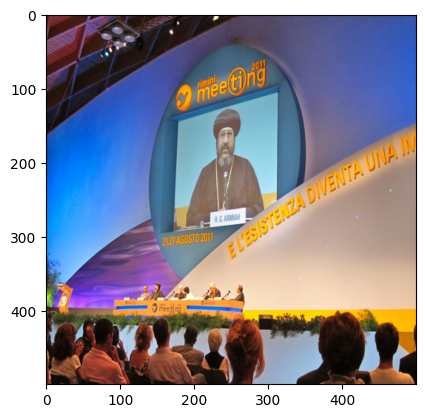

In [9]:
import matplotlib.pyplot as plt
import numpy as np 
idx = 5 
print("Question: ", dataset["train"][idx]["question"]) 
print("Answers: " ,dataset["train"][idx]["answers"])
im = np.asarray(dataset["train"][idx]["image"].resize((500,500)))
plt.imshow(im)
plt.show()

3. Next, we write the transform function to convert the image and text into
Tensors consumable by our model - For images, we use the transforms from
torchvision to convert to Tensor and resize to uniform sizes - For text,
we tokenize (and pad) them using the BertTokenizer from HuggingFace -
For answers (i.e. labels), we take the most frequently occuring answer
as the label to train with:




In [10]:
import torch
from torchvision import transforms
from collections import defaultdict
from transformers import BertTokenizer
from functools import partial

def transform(tokenizer, input):
  batch = {}
  image_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([224,224])])
  image = image_transform(input["image"][0].convert("RGB"))
  batch["image"] = [image]

  tokenized=tokenizer(input["question"],return_tensors='pt',padding="max_length",max_length=512)
  batch.update(tokenized)


  ans_to_count = defaultdict(int)
  for ans in input["answers"][0]:
    ans_to_count[ans] += 1
  max_value = max(ans_to_count, key=ans_to_count.get)
  ans_idx = answer_to_idx.get(max_value,0)
  batch["answers"] = torch.as_tensor([ans_idx])
  return batch

tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",padding="max_length",max_length=512)
transform=partial(transform,tokenizer)
dataset.set_transform(transform)

4. Finally, we import the flava_model_for_classification from
torchmultimodal. It loads the pretrained flava checkpoint by default and
includes a classification head.

The model forward function passes the image through the visual encoder
and the question through the text encoder. The image and question
embeddings are then passed through the multimodal encoder. The final
embedding corresponding to the CLS token is passed through a MLP head
which finally gives the probability distribution over each possible
answers.




In [11]:
from torchmultimodal.models.flava.model import flava_model_for_classification
model = flava_model_for_classification(num_classes=len(vocab))

flava_for_pretraining_unified_text_encoder.pt: 1.43GB [01:18, 18.2MB/s]                            


5. We put together the dataset and model in a toy training loop to
demonstrate how to train the model for 3 iterations:




In [12]:
from torch import nn
BATCH_SIZE = 2
MAX_STEPS = 3
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset["train"], batch_size= BATCH_SIZE)
optimizer = torch.optim.AdamW(model.parameters())


epochs = 1
for _ in range(epochs):
  for idx, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    out = model(text = batch["input_ids"], image = batch["image"], labels = batch["answers"])
    loss = out.loss
    loss.backward()
    optimizer.step()
    print(f"Loss at step {idx} = {loss}")
    if idx >= MAX_STEPS-1:
      break

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss at step 0 = 8.274225234985352
Loss at step 1 = 8.235435485839844
Loss at step 2 = 8.248086929321289


## Conclusion

This tutorial introduced the basics around how to finetune on a
multimodal task using FLAVA from TorchMultimodal. Please also check out
other examples from the library like
[MDETR](https://github.com/facebookresearch/multimodal/tree/main/torchmultimodal/models/mdetr)_
which is a multimodal model for object detection and
[Omnivore](https://github.com/facebookresearch/multimodal/blob/main/torchmultimodal/models/omnivore.py)_
which is multitask model spanning image, video and 3d classification.


